In [ ]:
import magni
from magni.cs.reconstruction.amp import run, config
from magni.cs.reconstruction.amp.util import theta_mm
import magni.utils.matrices as mat

import numpy as np
from scipy.misc import imresize
import scipy.ndimage as scimg
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr

from wavelets_self import Haar 

np.random.seed(1234)
np.set_printoptions(precision=3)
%matplotlib inline

%load_ext line_profiler

# NOTES
1. [DCT Notes](http://bugra.github.io/work/notes/2014-07-12/discre-fourier-cosine-transform-dft-dct-image-compression/)
2. [Magni Sample](http://magni.readthedocs.io/en/latest/magni.cs.reconstruction.amp._algorithm.html)

# CLASSES FOR COMPRESSIVE SENSING

In [35]:
class DCT():
    def dct2(self, x):
        return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

    def idct2(self, x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)
    
    """ Objective here is to see how k-sparse is the image? """
    def study_dct_k(self, url_img, nx=100, ny = 100, psnr_threshold = 25, show = False):
        img = scimg.imread(url_img, flatten=True, mode='L')
        img_resize = imresize(img, (nx,ny))/255.0
        alpha = dct2(img_resize)

        alpha_hist = np.sort(np.abs(alpha.ravel()))
        range_study = range(50,100,5)
        if show : f, axarr = plt.subplots(len(range_study), 1, figsize=(17,17))

        for i, perc_i in enumerate(range_study):
            alpha_10x_percentile_val = np.percentile(alpha_hist, perc_i)
            alpha_plt = alpha.copy()
            alpha_plt[(alpha_plt > -1*alpha_10x_percentile_val) & (alpha_plt < alpha_10x_percentile_val)] = 0
            k_sparse = len(np.nonzero(alpha_plt)[0])
            alpha_plt_idct2 = idct2(alpha_plt)
            if show : axarr[i].imshow(alpha_plt_idct2, cmap='gray')
            psnr = compare_psnr((img_resize).astype('float32'), alpha_plt_idct2.astype('float32'))
            if show : print (perc_i, 'th percentile:', alpha_10x_percentile_val, ' PSNR:', psnr, 'dB', ' ', k_sparse, '-sparse')

            if psnr >= psnr_threshold:
                k_sparse_res = k_sparse

        if show : print ('\nThreshold pSNR = ', psnr_threshold)
        if show : print ('N = ', nx*ny)
        if show : print ('k-sparse:', k_sparse_res)
        if show : print ('m = O(k*log(N)) ~ ', k_sparse_res * np.log(nx*ny))
        return k_sparse_res
    
class AMP():
    
    def __init__(self, dimension):
        self.dimension = dimension
        self.url_img = ''
        self.nx = 128
        self.ny = 128
        self.transform_basis = 'dct'
        self.show = 0
    
    def get_data(self):
        if self.dimension == 1:
            return self.get_data_1D()
        elif self.dimension == 2:
            return self.get_data_2D(self.url_img, nx = self.nx, ny = self.ny
                                    , transform_basis = self.transform_basis
                                    , show = self.show)
    
    def get_data_1D(self):
        k, m, N = 10, 200, 400
        A = 1 / np.sqrt(m) * np.random.randn(m, N)
        X = np.zeros((N, 1))
        X[:k] = np.random.normal(scale=1, size=(k, 1))
        y = A.dot(X)
        print ('Variable Shapes:', y.shape, A.shape, X.shape)
        return y, A, X, m, N

    def helper_X_transform(self, X, transform_basis):
        if transform_basis == 'dct':
            X = dct2(X)
        elif transform_basis == 'haar':
            # alpha = pywt.dwt2(img_resize, 'haar')
            haar = Haar()
            X = haar.dwt2d(X * 255.0)
        
        return X
    
    def helper_measurement_A(self, m, N):
        """
        A as a matrix of iid variables drawn from Gaussian or bernoulli distributions is inherently inchoherent with 
            all other sparsifying basis
        """
        """ 
        Notes
         - unable to create random A matrices for images above 100 x 100
         - need to find an in memory option
        """

        # A = 1 / np.sqrt(400) * np.random.randn(m, N)
        # A = np.random.randn(m, N)
        # A = np.random.choice([0,1], size=(k,N))
        A = np.empty((m, N), dtype=np.float16)
        A_size_mb = A.nbytes/1024.0/1024.0
        print ('Sensing Matrix : A (MB):', A_size_mb, ' A.shape:', A.shape)
        
        if A_size_mb < 2000:
            for i in range(m):
                A[i] = np.random.randn(1,N)[0]
            for j in range(A.shape[1]):
                A[:,j] = A[:,j]/np.sqrt(np.sum(np.abs(A[:,j]**2)))
            return A
        else:
            return []
    
    def get_data_2D(self, url_img, nx = 128, ny = 128, transform_basis = 'dct', MR = 0.6, show = False):
        
        ## Get the image, resize and transform
        img = scimg.imread(url_img, flatten=True, mode='L')
        img_resize = imresize(img, (nx,ny))/255.0
        print ('Img shape:', img.shape, ' Resized:', img_resize.shape)
        X = self.helper_X_transform(img_resize, transform_basis)
        
        if show : 
            f1, axarr1 = plt.subplots(1,2, figsize=(10,10))
            axarr1[0].imshow(img, cmap=plt.cm.gray)
            axarr1[1].imshow(img_resize, cmap=plt.cm.gray)

            f2, axarr2 = plt.subplots(1,2, figsize=(10,10))
            axarr2[0].imshow(X,cmap=plt.cm.Paired)
            axarr2[1].hist(np.log10(np.abs(X.ravel())), bins=100, color='#348ABD', alpha=.3, histtype='stepfilled')

        
        N = X.shape[1] * X.shape[0]
        m = int(N * MR)
        A = self.helper_measurement_A(m,N)
        
        
        if len(A):
            if X.shape[1] != 1:
                X = X.reshape((N,1))
            if np.amax(X) > 3:
                X = X/255
                print ('Max values of X:',np.amax(X))

            # measurement_style = 'random'
            measurement_style = 'linear'
            if measurement_style == 'random':
                rand_idxs = np.random.choice([0,1], size = m)
                y = X[rand_idxs]
            else:
                y = A.dot(X)

            print ('Variable Shapes:', y.shape, A.shape, X.shape)
            return y, A, X, m, N
        else:
            print ('MemoryError: For variable A')
            return [], [], [], 0, 0

    def get_data_2D_v2(self, url_img, show=False):
        # https://stats.stackexchange.com/questions/62416/image-reconstruction-using-compressed-sensing
        nx, ny = 100, 100
        N = nx*ny
        MR = 0.5
        k = int(N*MR)
        k = 4900

        img = scimg.imread(url_img, flatten=True, mode='L')
        img_resize = imresize(img, (nx,ny))/255

        Atemp = np.zeros((1, N))
        idxs = np.random.permutation(np.arange(1, N))
        rand_idxs = sorted(idxs[1:k+1])

        A = np.zeros((k, N))
        for i, idx in enumerate(rand_idxs):
            Atemp[0,idx] = 1
            A[i, :] = spfft.dct(Atemp)
            Atemp[0, idx] = 0

        alpha = img_resize.reshape(N,1)
        y = alpha[rand_idxs]

        if show:
            f, axarr = plt.subplots(1,3)
            axarr[0].imshow(img, cmap = plt.cm.gray)
            axarr[1].imshow(img_resize, cmap = plt.cm.gray)
            axarr[2].imshow(y.reshape((70,70)), cmap = plt.cm.gray)

        print ('Variable Shapes:', y.shape, A.shape, alpha.shape)
        return y, A, alpha
    
    def amp_solver(self, y, A, X, m, N):
        config['threshold_parameters'] = {'threshold_level_update_method': 'residual',
                                    'theta': theta_mm(float(m) / N)   #regularization param for thresholding func
                                  , 'tau_hat_sq': 1.0
                                 }
        config['report_history'] = True
        alpha_hat, history = run(y, A)
        residual = np.abs(alpha - alpha_hat) > 1e-2
        residual = np.abs(alpha - alpha_hat)
        residual_max = residual.max()

        print ('\n -------------------------------------------------- ')
        #print ('Residual:', residual, ' Max residual:',residual_max ,' SUM:', np.sum(residual))
        # print ('alpha_hat:', alpha_hat)
        # print ('alpha:', alpha)
        print ('Max residual:',residual_max ,' SUM:', np.sum(residual))
        print ('pSNR (of iterative algo):', compare_psnr(alpha.astype('float32'), alpha_hat.astype('float32')))

        if basic == 0:
            if transform_basis == 'dct':
                alpha_hat_plt = idct2(alpha_hat.reshape((nx, ny)))
            elif transform_basis == 'haar':
                haar = Haar()
                alpha_hat_plt = haar.idwt2d(alpha_hat.reshape((nx, ny)))

            print ('pSNR (of transform basis):', compare_psnr(alpha.reshape((nx,ny)).astype(np.float32), alpha_hat_plt.astype(np.float32)))
            plt.imshow(alpha_hat_plt, cmap = plt.cm.gray)
    
# url_img = '../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
# k = study_dct_k(url_img, show=0)
# --> %lprun -f get_data_img get_data_img(url_img, show=0)

if __name__ == "__main__":
    """ CS STUDY """
    dimension = 2
    amp = AMP(dimension)
    
    if dimension == 1:
        y, A, X, m, N = amp.get_data()
    else:
        amp.url_img = '../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
        amp.nx = 128
        amp.ny = 128
        amp.transform_basis = 'haar'
        y, A, X, m, N = amp.get_data()

----------------- CONFIG VALUES -------------------------
dict_keys(['convert', 'threshold_parameters', 'AH_dot_chi', 'delta', 'stop_criterion', 'chi', 'history', 'true_solution', 'iterations', 'report_history', 'AH', 'alpha_bar', 'stop_criterion_name', 'tolerance', 'threshold'])
iterations: 300
Thresholding function: <magni.cs.reconstruction.amp.threshold_operator.SoftThreshold object at 0x7f715b5d3f28>
Threshold parameters: {'theta': 0.745, 'threshold_level_update_method': 'residual', 'tau_hat_sq': 1.0}
Convert: <class 'numpy.float64'>
Stop criterion: <magni.cs.reconstruction.amp.stop_criterion.MSEConvergence object at 0x7f715b5d3780>
Tolerance: 1e-06
----------------- CONFIG VALUES -------------------------
Iter: 0 / 300
Error: 3.83390078167e-06
Error: 5.73615078923e-05
Error: 2.69736093622e-05
Error: 1.29981051904e-05
Error: 6.50055069184e-06
Error: 3.51138500644e-06
Error: 2.07741306812e-06
Error: 1.35633006526e-06
Error: 9.41728569395e-07
Total Iterations: 8

 -------------------

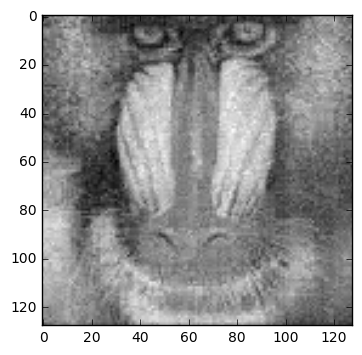

In [36]:
amp.amp_solver(y, A, X, m, N)

# SAMPLE FROM DOCS


# EXPERIMENTATION

In [4]:
# y=zeros(m,1);
#     remaining_columns=n;
#     K=4096;%How large each submatrtix is.  Determines memory usage
#     iters=ceil(n/K);
#     for i=0:iters-1
#         rng(i);
#         col_num=min(K,remaining_columns);
#         phi_columns=randn(m,col_num);
#         column_norms=sqrt(sum(abs(phi_columns).^2,1));
#         phi_columns=bsxfun(@rdivide,phi_columns,column_norms);
#         y=y+phi_columns*x(K*i+1:K*i+col_num);
#         remaining_columns=remaining_columns-K;
#     end
# end

N = 100 * 100
m = 5000
y = np.zeros(m,1)
K = 4096 #size of submatrix
iters = np.ceil(N/K)

remaining_columns = N
for i in range(iters):
    np.random.seed(i)
    col_num = min(K, remaining_columns)
    phi_columns = np.random.randn(m, col_num)

TypeError: data type not understood